# <center>CMPBIO210, IB120, IB201
# <center>"Introduction to Quantitative Methods in Biology"
# <center>Lecture 2. Differential Equations Intro  
## <center>Denis Titov

**The main goal of this jupyter notebook is to introduce you to the calculus apporach of answering questions.  
A secondary goal is to introduce you to numerical and analytical solutions of differential equations using Python with SciPy solve_ivp() and SymPy dsolve(), respectively**

A major goal of science is to understand how things work so that we can predict how a system will evolve over time given initial conditions.  
Differential equations is the mathematical tool that scientists use to achieve this goal.  
  
Some examples of systems that can be described using differentail equations:
- calculate changes of concentration of metabolites over time given enzyme reaction rates and concentrations at time=0
- calculate changes in mRNA and protein concentration over time given transcription, translation, degradation rates and concentrations at time=0
- calculate changes in the size of populations over time given growth rates and population sizes at time=0  
- calculate the number of infected people given virus transmission rates and number of people at t=0
- calculate changes of position of objects over time given speed, acceleration and positions at time=0  
  
Differential equations are also useful for studying things other than time (e.g. but most biology application involve time so we'll focus on time).
  


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from scipy.integrate import solve_ivp

## Let's re-discover calculus by attempting to answer the following question

Let's say we know a rate of something changing over time. For example, 
  
Enzyme Rate - change of Enzyme Product concentration $[P]$ over a period of time $\frac{\Delta [P]}{\Delta t}=\frac{[P]_{t_2}-[P]_{t_1}}{t_2-t_1}$  
  
Growth Rate - change of Population of Individuals $N$ over a period of time $\frac{\Delta N}{\Delta t}=\frac{N_{t_2}-N_{t_1}}{t_2-t_1}$  
  
Object Velocity - change of Car Position $x$ over a period of time $\frac{\Delta x}{\Delta t}=\frac{x_{t_2}-x_{t_1}}{t_2-t_1}$   
  

What will happen to $[P]$, $N$ or $x$ at any point in time in the future given starting values $[P]_0$, $N_0$ or $x_0$ and corresponding rates $\frac{\Delta [P]}{\Delta t}$, $\frac{\Delta N}{\Delta t}$ and $\frac{\Delta x}{\Delta t}$?  

#### Let's start by figuring out what happens when $\frac{\Delta [P]}{\Delta t}$, $\frac{\Delta N}{\Delta t}$ and $\frac{\Delta x}{\Delta t}$ are constant (i.e., $\frac{\Delta [P]}{\Delta t}=Some Number$)  
If $\frac{\Delta [P]}{\Delta t}$ is constant then $[P](t)=[P]_0 + \frac{\Delta [P]}{\Delta t} * t$

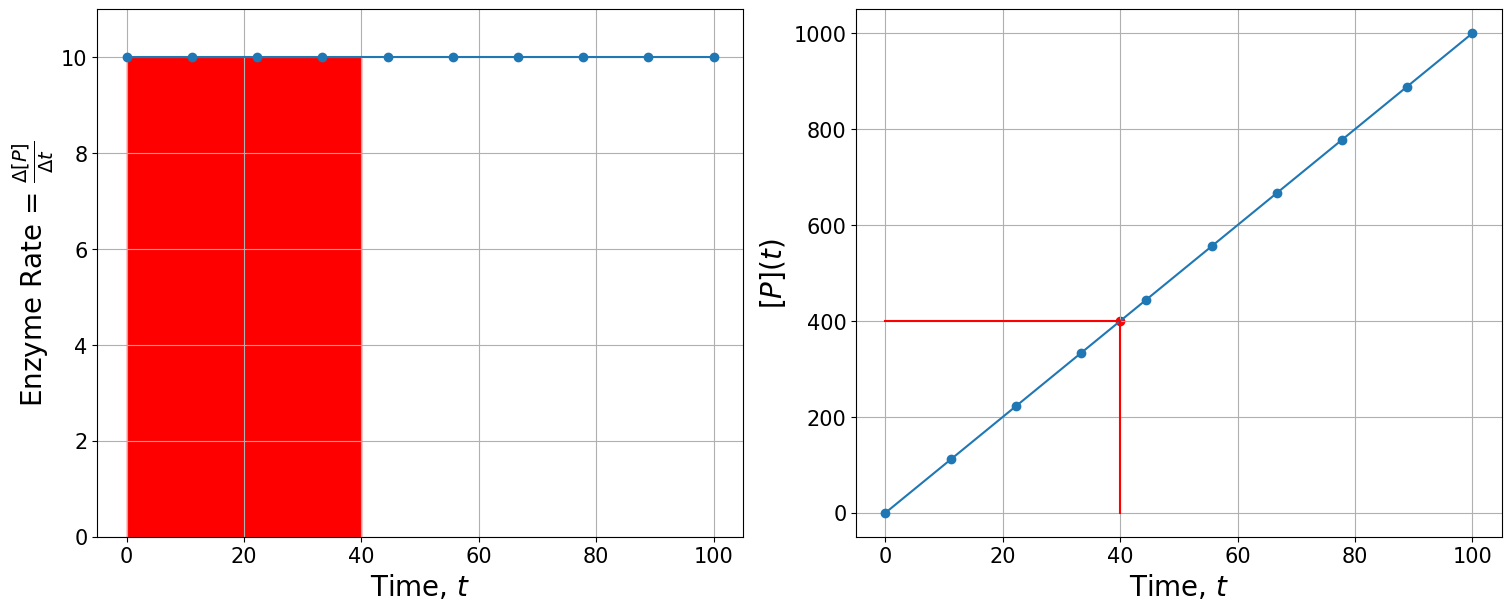

In [2]:
EnzymeRate = 10
InitialProduct = 0

# Make arrays of timepoints and corresponding enzyme rates that we can then plot using parameters above
number_of_timepoints = 10  # Try changing "number_of_timepoints"
final_timepoint = 100
time_array = np.linspace(0, final_timepoint, number_of_timepoints)
enzyme_rate_array = EnzymeRate * np.ones(number_of_timepoints)

# Let's plot the arrays that we made above
fig, axs = plt.subplots(
    nrows=1, ncols=2, figsize=(15, 6), dpi=100, constrained_layout=True
)
axs[0].plot(time_array, enzyme_rate_array, marker="o")
axs[1].plot(time_array, enzyme_rate_array * time_array, marker="o")

# Let's add filled surface under the Enzyme Rate and corresponding [P] point
timepoint = 40  # Try changing "timepoint"
axs[0].fill_between([0, timepoint], [EnzymeRate, EnzymeRate], color="red")
axs[1].scatter([timepoint], [EnzymeRate * timepoint], c="red")
axs[1].plot(
    [0.0, timepoint, timepoint],
    [EnzymeRate * timepoint, EnzymeRate * timepoint, 0.0],
    c="red",
)

# Let's beautify the plot a bit by adding axis labels and increase font
axs[0].set_ylabel(r"Enzyme Rate = $\frac{\Delta [P]}{\Delta t}$", fontsize=20)
axs[0].set_ylim(0, 1.1 * EnzymeRate)
axs[1].set_ylabel("$[P](t)$", fontsize=20)

for ax in axs:
    ax.tick_params(labelsize=15)
    ax.grid(which="major", axis="both")
    ax.set_xlabel("Time, $t$", fontsize=20)

#### Now let's do the same calculation as above but for non-constant $\frac{\Delta [P]}{\Delta t}$, $\frac{\Delta N}{\Delta t}$ and $\frac{\Delta x}{\Delta t}$ (i.e., $\frac{\Delta [P]}{\Delta t}=f([P], t)$)  
Let's use $\frac{\Delta [P]}{\Delta t}=-t$ as an example but principle is the same for any $\frac{\Delta [P]}{\Delta t}=f([P], t)$  
Let's plot $\frac{\Delta [P]}{\Delta t}=-t$. The detailed text explaining an approach to make this calculation is after the code for plotting.

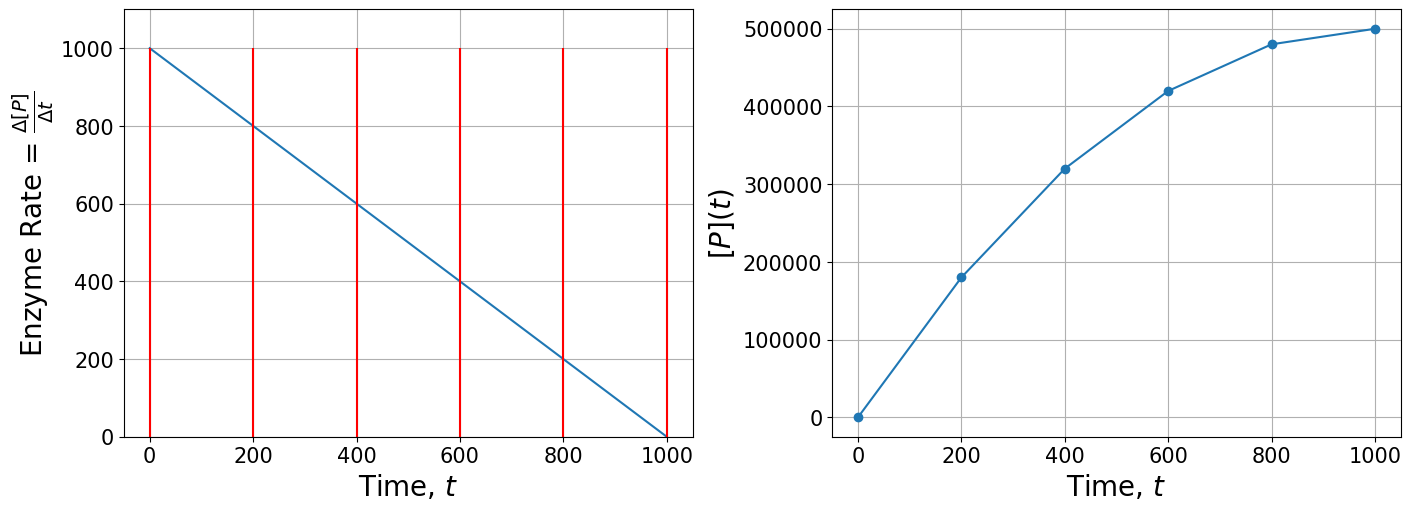

In [3]:
InitialEnzymeRate = 1000
InitialProduct = 0

# Make arrays of timepoints and corresponding enzyme rates that we can then plot using parameters above
number_of_timepoints = 10_000
final_timepoint = 1000
time_array = np.linspace(0, final_timepoint, number_of_timepoints)
enzyme_rate_array = InitialEnzymeRate * np.ones(number_of_timepoints) - time_array

fig, axs = plt.subplots(
    nrows=1, ncols=2, figsize=(14, 5), dpi=100, constrained_layout=True
)
axs[0].plot(time_array, enzyme_rate_array);

# Let's calculate [P] by dividing time_array into segments and assuming that withing
# each segment the rate is constant and equal to mean rate in the segment
divider = 5  # change this value to higher value to get a better approximation (cannot be higher than final_timepoint due to how I implemented the code but in theory could be any number)

# Lets plot the segments on top of Rate plot to visualize it
axs[0].vlines(
    range(0, final_timepoint + 1, final_timepoint // divider),
    0,
    InitialEnzymeRate,
    color="red",
)

# Lets calculate [P] using the mean Rate in each segment
Calc_P = [InitialProduct]
Calc_time = [0]
Sum_P = InitialProduct
segment_size = number_of_timepoints // divider
for t in range(1, divider + 1):
    Calc_time = np.append(Calc_time, time_array[t * segment_size - 1])
    Time_period = Calc_time[t] - Calc_time[t - 1]
    Mean_rate = np.mean(
        enzyme_rate_array[(t - 1) * segment_size : t * segment_size - 1]
    )
    Sum_P += Time_period * Mean_rate
    Calc_P = np.append(Calc_P, Sum_P)

# Plot the calculated [P] using segmentation idea
axs[1].plot(Calc_time, Calc_P, marker="o")

# Let's beautify the plot a bit by adding axis labels and increase font
axs[0].set_ylabel(r"Enzyme Rate = $\frac{\Delta [P]}{\Delta t}$", fontsize=20)
axs[0].set_ylim(0, 1.1 * InitialEnzymeRate)
axs[1].set_ylabel("$[P](t)$", fontsize=20)

for ax in axs:
    ax.tick_params(labelsize=15)
    ax.grid(which="major", axis="both")
    ax.set_xlabel("Time, $t$", fontsize=20)

I propose as an approach to answering the question above we simply divide the time into several segments and assume $\frac{\Delta [P]}{\Delta t}$ is constant in each segment so within a segment we can use the same simple arithmetic calculation as above $[P]_{t_2}=[P]_{t_1} + \frac{\Delta [P]}{\Delta t} * (t_2-t_1)$  
So then we can do a series of calculation like this for each segment:  
$[P]_{t_1}=[P]_{0} + mean(\frac{\Delta [P]}{\Delta t})_{segment_{0->t_1}} \cdot (t_1-0)$  
$[P]_{t_2}=[P]_{t_1} + mean(\frac{\Delta [P]}{\Delta t})_{segment_{t_1->t_2}} \cdot (t_2-t_1)$  
$[P]_{t_3}=[P]_{t_2} + mean(\frac{\Delta [P]}{\Delta t})_{segment_{t_2->t_3}} \cdot (t_3-t_2)$  
...  
$[P]_{t_n}=[P]_{t_{n-1}} + mean(\frac{\Delta [P]}{\Delta t})_{segment_{t_{n-1}->t_n}} \cdot (t_{n}-t_{n-1})$  
Our answer will be more and more accurate if we take a smaller and smaller $t_{n}-t_{n-1}$ segments.  

#### What we just did above is really the essence of calculus approach - subdividing a calculation into many segments, assume things are linear in each segment and can be easily calculated and then reassembling the calculation from each segment into the final answer.  
#### Many tricks have been invented over the last several centuries about how to do the trick but the idea is the same.  
Another way to describe what we did above is to say that we solved the following differential equations:  
$\frac{d[P](t)}{dt} = InitialEnzymeRate-t$  with initial condition $[P]_0 = 0$  
Yet another way to describe what we did above is to say that we calculated the following integral:  
$[P](t)=\int_{0}^{t}(InitialEnzymeRate-t)dt $  
#### Any differential equation or integral can be solved using the computer and the trick above where as a solution you get a list of numbers like we did above. This is called a numerical solution.    
A small fractiong of differential equations can be solved exactly (i.e. find $[P](t)=f(P,t)$ instead of finding a list of numbers like we did in a numerical solution) using trick taught in undergrad differential equations classes. This is called an analytical solution and computers can be used to analytical solution in the cases where they exist. 
#### We will exclusively use computers to solve differential equations during this class and mostly use numerical solutions since most practically interesting problems cannot be solved exactly and using a computer is "easy".

## Numerical solution of $\frac{d[P](t)}{dt}=InitialEnzymeRate-t$
**We will have a whole lecture about numerical solutions of differential equations.**  
We can solve $\frac{d[P](t)}{dt}=InitialEnzymeRate-t$  numerically (i.e. find numbers that correspond to a solution without finding an exact function) using SciPy library that allows numerical calculations in Python.  

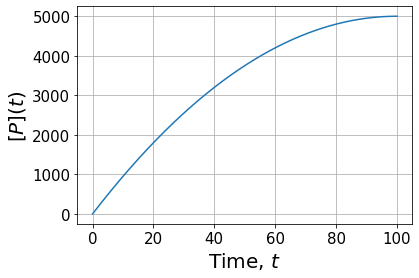

In [4]:
# %%timeit

# "%%timeit" command above is called a "magic command" and
# this command allows you to measure code execution time
# uncomment it to see how fast the differential solution is

InitialEnzymeRate = 100
final_timepoint = 100
number_of_timepoints = 10_000

# Numerically solve diff equations (dPdt = InitialEnzymeRate - t)
# given P0=0 for time points (tspan=[0,final_timepoint]) and save all timepoints in t_eval

# Write down differential equation to be solved
# Change this differential equation to other functions that depend on t to find their solutions
def ODE(t, y):
    dPdt = InitialEnzymeRate - t
    return dPdt


# Write down initial condition and tspan of time that we want the solution at
P0 = [0]
tspan = [0, final_timepoint]
# Actual solution is just this one line
soln = solve_ivp(
    ODE, tspan, P0, t_eval=np.linspace(0, final_timepoint, number_of_timepoints)
)

# Lets plot the solution
plt.plot(soln.t, soln.y[0])
plt.ylabel("$[P](t)$", fontsize=20)
plt.tick_params(labelsize=15)
plt.grid(which="major", axis="both")
plt.xlabel("Time, $t$", fontsize=20);

*solve_ivp()* has a lot of various options for using specific algorythms, introducing events etc that you can lookup using *solve_ivp?* and that we will review during our numerical calculations lecture

In [5]:
solve_ivp?

Signature:
solve_ivp(
    fun,
    t_span,
    y0,
    method='RK45',
    t_eval=None,
    dense_output=False,
    events=None,
    vectorized=False,
    args=None,
    **options,
)
Docstring:
Solve an initial value problem for a system of ODEs.

This function numerically integrates a system of ordinary differential
equations given an initial value::

    dy / dt = f(t, y)
    y(t0) = y0

Here t is a 1-D independent variable (time), y(t) is an
N-D vector-valued function (state), and an N-D
vector-valued function f(t, y) determines the differential equations.
The goal is to find y(t) approximately satisfying the differential
equations, given an initial value y(t0)=y0.

Some of the solvers support integration in the complex domain, but note
that for stiff ODE solvers, the right-hand side must be
complex-differentiable (satisfy Cauchy-Riemann equations [11]_).
To solve a problem in the complex domain, pass y0 with a complex data type.
Another option always available is to rewrite your pro

## Analytical solution of $\frac{d[P](t)}{dt}=InitialEnzymeRate-t$
**We will have a whole lecture about analytical solutions of differential equations.**  
We can solve $\frac{d[P](t)}{dt}=InitialEnzymeRate-t$  analytically (i.e. find an exact function so that $P(t)=f(t)$) using SymPy library that allows symbolic calculations in Python.  

In [6]:
InitialEnzymeRate = 10

# In order to do symbolic calculations we need to tell the computer
# what is a function and what is a variable
P = sym.symbols("P", cls=sym.Function)  # this defines N as a function
t, P0 = sym.symbols("t, P0")  # this defines t and N0 as variable

# Write the differential equation that we want to solve
# Change this differential equation to other functions that depend on t to find their solutions
Equation = sym.Eq(sym.diff(P(t), t), InitialEnzymeRate - t)
# Solve differential equation
sym.dsolve(Equation, P(t), ics={P(0): 0})

Eq(P(t), -t**2/2 + 10*t)

In [13]:
[sym.Eq(sym.diff(x(t), t), y(t)),sym.Eq(sym.diff(y(t), t), x(t))]

[Eq(Derivative(x(t), t), y(t)), Eq(Derivative(y(t), t), x(t))]

In [19]:
x,y = sym.symbols("x, y", cls=sym.Function)
t = sym.symbols("t")  # this defines t and N0 as variable

Equations = [sym.Eq(sym.diff(x(t), t), y(t)), sym.Eq(sym.diff(y(t), t), x(t))]
sym.dsolve(Equations,[x(t),y(t)], ics={x(0):1,y(0):1})

[Eq(x(t), exp(t)), Eq(y(t), exp(t))]

*The above three lines of code will solve any differential equation from a Differential Equations textbook (i.e. any differential equation that has an analytical solution) highlighting the power of python and SymPy.*  
  
Try this textbook avalable online if interested: https://archive.org/details/C.HenryEdwardsDavidE.PenneyElementaryDifferentialEquations6thEdition/page/n13/mode/1up